In [1]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x
    
class CLIP(nn.Module):
    def __init__(self,
             embed_dim: int,
             # vision (for both high-field and low-field)
             image_resolution: int,
             vision_layers: Union[Tuple[int, int, int, int], int],
             vision_width: int,
             vision_patch_size: int):
        super().__init__()

        # High-field visual encoder
        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual_high_field = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual_high_field = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        # Low-field visual encoder
        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual_low_field = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual_low_field = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        # Logit scale for cosine similarity (optional for specific tasks)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def encode_image_high_field(self, image):
        return self.visual_high_field(image)

    def encode_image_low_field(self, image):
        return self.visual_low_field(image)

    def forward(self, image_high_field, image_low_field):
        # Encode both high-field and low-field images
        image_features_high_field = self.encode_image_high_field(image_high_field)
        image_features_low_field = self.encode_image_low_field(image_low_field)

        # Normalize features
        image_features_high_field = image_features_high_field / image_features_high_field.norm(dim=1, keepdim=True)
        image_features_low_field = image_features_low_field / image_features_low_field.norm(dim=1, keepdim=True)

        # Compute cosine similarity (logits) between high-field and low-field image features
        logit_scale = self.logit_scale.exp()
        logits_per_high_field_image = logit_scale * image_features_high_field @ image_features_low_field.t()
        logits_per_low_field_image = logits_per_high_field_image.t()

        # Return similarity between high-field and low-field images
        return logits_per_high_field_image, logits_per_low_field_image


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)

In [2]:
import torch
import os
from tqdm import tqdm
from tqdm import trange
import random
import torch.nn.functional as F
import torch
import monai.networks.nets as nets

def mae_masking(image, num_patches=14, mask_ratio=0.75):
    """
    MAE 风格的 Patch Masking。

    Args:
        image (torch.Tensor): 输入图像 (B, C, H, W)。
        num_patches (int): 每行/列划分的 patch 数量（最终 N = num_patches × num_patches）。
        mask_ratio (float): Mask 的 patch 比例。

    Returns:
        masked_image (torch.Tensor): 经过 Mask 处理的图像 (B, C, H, W)。
        mask (torch.Tensor): 0-1 mask，标记哪些 patch 被 Mask 掉 (B, N)。
    """
    B, C, H, W = image.shape
    patch_h, patch_w = H // num_patches, W // num_patches  # 每个 patch 的大小
    N = num_patches * num_patches  # 总 Patch 数量
    
    # **1. 拆分成 patch**
    patches = image.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)  # (B, C, num_patches, num_patches, patch_h, patch_w)
    patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B, N, C, patch_h, patch_w)  # (B, N, C, patch_h, patch_w)

    # **2. 生成 Mask**
    mask = torch.rand(B, N, device=image.device)  # (B, N)
    mask = mask < mask_ratio  # 75% 变成 True
    mask = mask.float().unsqueeze(2).unsqueeze(3).unsqueeze(4)  # (B, N, 1, 1, 1)

    # **3. 只 Mask 掉 Patch，而不是整个图像**
    min_value = image.min()
    masked_patches = patches * (1 - mask) + min_value * mask  # 被 Mask 的部分填充 min_value（如 0）

    # **4. 重组回原图**
    masked_image = masked_patches.reshape(B, num_patches, num_patches, C, patch_h, patch_w)
    masked_image = masked_image.permute(0, 3, 1, 4, 2, 5).reshape(B, C, H, W)  # (B, C, H, W)

    return masked_image






2025-02-15 16:17:59.725210: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-15 16:17:59.814596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-15 16:18:02.377491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import numpy as np
import torch
images_array = np.load('/media/NAS07/USER_PATH/zzx/npy/npy_filtered/M4W_filtered_train.npy')[:,np.newaxis,np.newaxis,:,:]
images_tensor_m4w = torch.tensor(images_array, dtype=torch.float32)
print(images_tensor_m4w.shape)

images_array = np.load('/media/NAS07/USER_PATH/zzx/npy/npy_filtered/LISA_filtered_train.npy')[:,np.newaxis,np.newaxis,:,:]
images_tensor_lisa = torch.tensor(images_array, dtype=torch.float32)
print(images_tensor_lisa.shape)

images_array = np.load('/media/NAS07/USER_PATH/zzx/npy/npy_filtered/fast_mri_filtered_train.npy')[:,np.newaxis,np.newaxis,:,:]
images_tensor_fastmri = torch.tensor(images_array, dtype=torch.float32)
print(images_tensor_fastmri.shape)

images_array = np.load('/media/NAS07/USER_PATH/zzx/npy/npy_filtered/HCP_filtered_train.npy')[:,np.newaxis,np.newaxis,:,:]
images_tensor_hcp = torch.tensor(images_array, dtype=torch.float32)
print(images_tensor_hcp.shape)

torch.Size([6232, 1, 1, 120, 120])
torch.Size([2311, 1, 1, 120, 120])
torch.Size([4878, 1, 1, 120, 120])
torch.Size([7833, 1, 1, 120, 120])


In [4]:
device = 'cuda:0'
batch_size = 1
channels = 1
depth = 32
height = 128
width = 128
# Real_A = images_tensor_lisa.to(device)  # 模拟域A
Real_A = torch.cat([images_tensor_m4w, images_tensor_lisa], dim=0)[:8000] # 模拟域A
pi_A = np.random.permutation(Real_A.shape[0])
# Real_B = images_tensor_hcp.to(device)  # 模拟域B
Real_B = torch.cat([images_tensor_hcp, images_tensor_fastmri], dim=0)[:8000]  # 模拟域B
pi_B = np.random.permutation(Real_B.shape[0])
print(Real_A.shape,Real_B.shape)
Real_A = Real_A[pi_A].view(500, 1, 16, 120, 120).permute(0, 2, 1, 3, 4)
Real_B = Real_B[pi_B].view(500, 1, 16, 120, 120).permute(0, 2, 1, 3, 4)
print(Real_A.shape,Real_B.shape)
num_epochs = 10

torch.Size([8000, 1, 1, 120, 120]) torch.Size([8000, 1, 1, 120, 120])
torch.Size([500, 16, 1, 120, 120]) torch.Size([500, 16, 1, 120, 120])


In [7]:
image_resolution = 120  # 图像分辨率224x224
vision_patch_size = 16  # 假设每个patch是16x16
vision_width = 256  # 图像编码器的宽度
embed_dim = 512  # 嵌入维度
# 初始化模型
device = 'cuda:1'
with torch.no_grad():
    model_SGP = CLIP(embed_dim, image_resolution, vision_layers=6, vision_width=vision_width, vision_patch_size=vision_patch_size).to(device)
    model_SGP.load_state_dict(torch.load('/media/NAS07/USER_PATH/zzx/weight/clip_1.pth'),True)
    model_LSC = nets.UNet(
        spatial_dims=2,  # 2D UNet（如果是 3D MRI 就用 spatial_dims=3）
        in_channels=1,   # 输入通道数（灰度图 1，RGB 3）
        out_channels=1,  # 输出通道数（单通道分割）
        channels=(16, 32, 64, 128, 256),  # UNet 层通道数
        strides=(2, 2, 2, 2),  # 池化步长
        num_res_units=2 ).to(device)
    model_LSC.load_state_dict(torch.load('/media/NAS07/USER_PATH/zzx/weight/unet_weights_rotate.pth'),True)

torch.Size([16, 1, 120, 120])
torch.Size([16, 1, 120, 120])
0.28716996 0.009531649


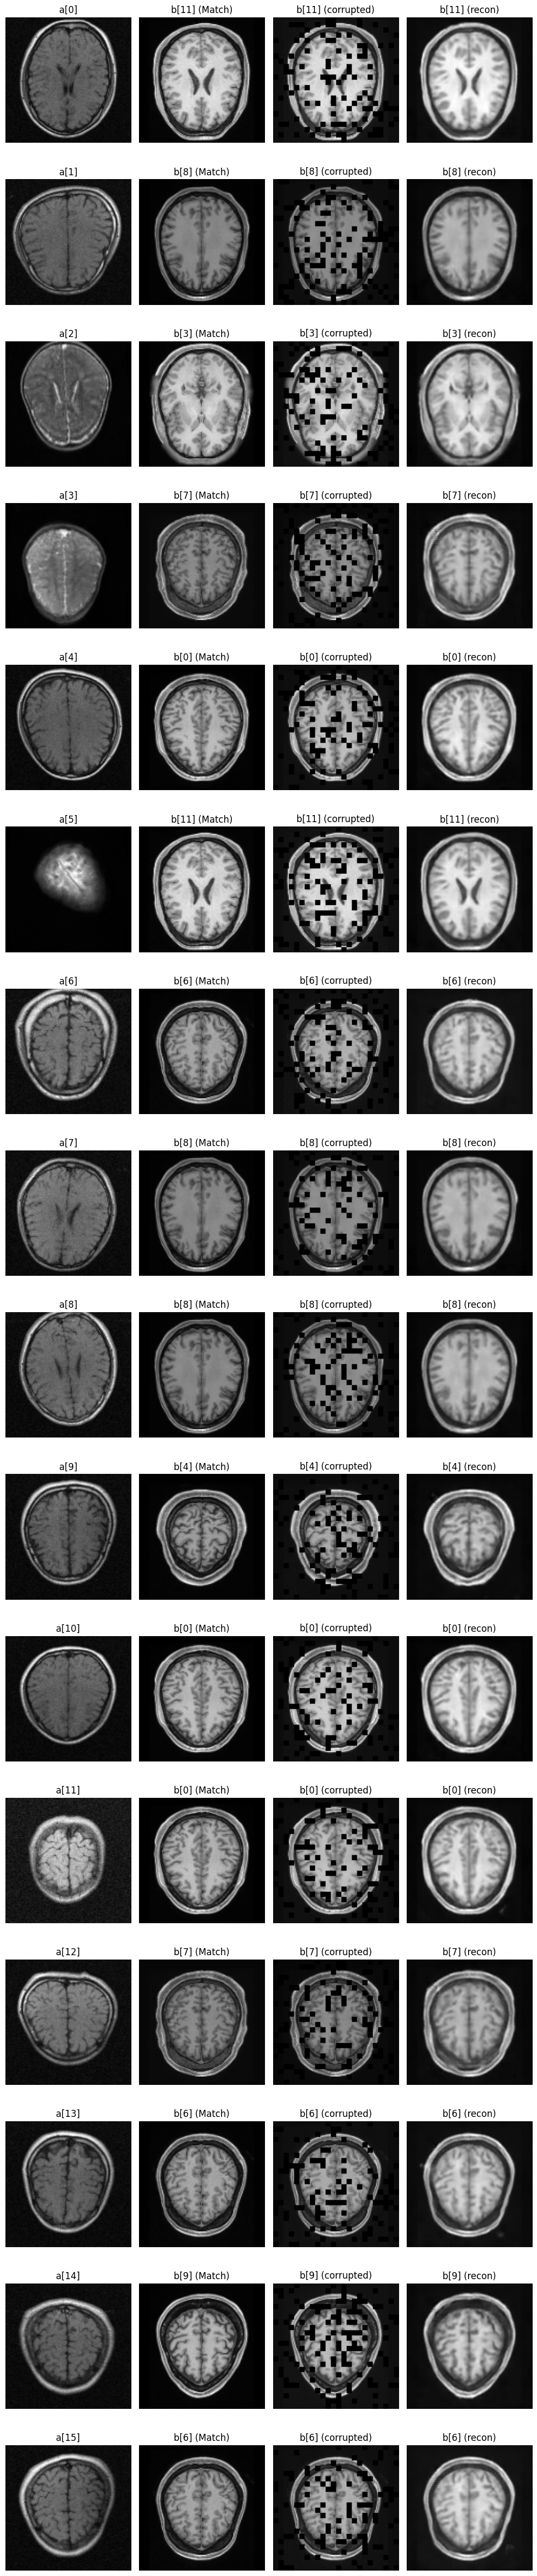

In [9]:
import numpy as np
i = 1
image_high_field = Real_B[i].to(device)
image_low_field = Real_A[i].to(device)
print(image_high_field.shape)
with torch.no_grad():
    image_high_field_features = model_SGP.encode_image_high_field(image_high_field).float()
    image_low_field_features = model_SGP.encode_image_low_field(image_low_field).float()
image_high_field_features /= image_high_field_features.norm(dim=-1, keepdim=True)
image_low_field_features /= image_low_field_features.norm(dim=-1, keepdim=True)
similarity = image_low_field_features.cpu().numpy() @ image_high_field_features.cpu().numpy().T
# 计算最佳匹配索引
matching = np.argmax(similarity, axis=1)  # 找到每个 a[i] 最匹配的 b[j]

# 重新排序 b
image_high_field_prime = image_high_field[matching]  # 重新排列 b，使其与 a 的最佳匹配顺序一致
image_high_field_preprocess = mae_masking(image_high_field_prime, num_patches=24, mask_ratio=0.2)
print(image_high_field_preprocess.shape)
image_high_field_preprocess1 = F.interpolate(image_high_field_preprocess, size=(128, 128), mode='bilinear')
image_high_field_recon = model_LSC(image_high_field_preprocess1)
# image_high_field_recon = F.interpolate(image_high_field_recon, size=(120, 120), mode='bilinear')
print(np.mean(image_high_field_recon[i, 0].cpu().detach().numpy()),np.mean(image_high_field_preprocess[i, 0].cpu().detach().numpy()))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(16, 4, figsize=(10, 48))
for i in range(16):
    # 显示 a[i]
    axes[i, 0].imshow(image_low_field[i, 0].cpu(), cmap="gray")
    axes[i, 0].set_title(f"a[{i}]")
    axes[i, 0].axis("off")

    # 显示 b_prime[i]
    axes[i, 1].imshow(image_high_field_prime[i, 0].cpu(), cmap="gray")
    axes[i, 1].set_title(f"b[{matching[i]}] (Match)")
    axes[i, 1].axis("off")
    
    # 显示 b_prime[i]
    axes[i, 2].imshow(image_high_field_preprocess[i, 0].cpu(), cmap="gray")
    axes[i, 2].set_title(f"b[{matching[i]}] (corrupted)")
    axes[i, 2].axis("off")
    
    axes[i, 3].imshow(image_high_field_recon[i, 0].cpu().detach().numpy(), cmap="gray")
    axes[i, 3].set_title(f"b[{matching[i]}] (recon)")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制图像
fig, ax = plt.subplots()
im = ax.imshow(similarity, vmin=0.1, vmax=0.4, cmap='viridis')

# 添加具体数值
for i in range(similarity.shape[0]):
    for j in range(similarity.shape[1]):
        value = f"{similarity[i, j]:.2f}"  # 保留两位小数
        ax.text(j, i, value, ha='center', va='center', color='white', fontsize=6)

# 调整坐标轴
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position("bottom")

# 添加颜色条
cbar = plt.colorbar(im, pad=0.1)
plt.show()